In [2]:
import scipy.io as sio
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from ltar import LTAR, diff, invert_diff

In [24]:
nasdaq = sio.loadmat('data/nasdaq100.mat')
len(nasdaq["X"])

2186

In [46]:
tensor_shape = (2186, 50, 4)
tensor_data = np.zeros(tensor_shape)
for i in range(tensor_shape[0]):
    tensor_data[i] = nasdaq['X'][i][0]
tensor_data.shape

(2186, 50, 4)

In [47]:
N = 2186
N_train = 2000
N_test = N - N_train

<AxesSubplot:>

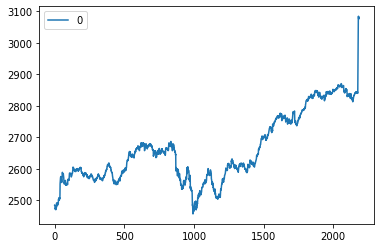

In [48]:
norms = []
for i in range(N):
    norms.append(np.linalg.norm(tensor_data[i], ord="fro"))
pd.DataFrame(norms).plot()

In [49]:
train_tensor = jts.extract_train_tensor(tensor_data, N_train)
test_tensor = jts.extract_test_tensor(tensor_data, N_train, N_test)

# LSTM

In [51]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        start_ix = i - n_steps
        # check if we are beyond the sequence
        if start_ix >= 0:
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[start_ix:i], sequence[i]
            X.append(seq_x)
            y.append(seq_y)
    return np.asarray(X), np.asarray(y)
n_steps = 10
sequence = tensor_data.reshape((N, 200))
X, y = split_sequence(sequence, n_steps)
X.shape

(2176, 10, 200)

In [52]:
N = 2186
lstm_N_train = 2000 - n_steps
lstm_N_test = N - N_train

In [53]:
train_X = X[:lstm_N_train]
train_X.shape

(1990, 10, 200)

In [54]:
train_y = y[:lstm_N_train]
train_y.shape

(1990, 200)

In [55]:
test_X = X[lstm_N_train:lstm_N_train+lstm_N_test]
test_X.shape

(186, 10, 200)

In [56]:
test_y = y[lstm_N_train:lstm_N_train+lstm_N_test]
test_y.shape

(186, 200)

In [57]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
n_features = 200
model.add(LSTM(200, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_y, epochs=200, verbose=1)

Epoch 1/200
63/63 [==============================] - 15s 11ms/step - loss: 59965.9587
Epoch 2/200
63/63 [==============================] - 1s 11ms/step - loss: 17229.8207
Epoch 3/200
63/63 [==============================] - 1s 11ms/step - loss: 425.2610
Epoch 4/200
63/63 [==============================] - 1s 11ms/step - loss: 78.1697
Epoch 5/200
63/63 [==============================] - 1s 11ms/step - loss: 77.2874
Epoch 6/200
63/63 [==============================] - 1s 11ms/step - loss: 76.0881
Epoch 7/200
63/63 [==============================] - 1s 11ms/step - loss: 74.7834
Epoch 8/200
63/63 [==============================] - 1s 11ms/step - loss: 74.9312
Epoch 9/200
63/63 [==============================] - 1s 11ms/step - loss: 73.6806
Epoch 10/200
63/63 [==============================] - 1s 11ms/step - loss: 72.6329
Epoch 11/200
63/63 [==============================] - 1s 11ms/step - loss: 73.5471
Epoch 12/200
63/63 [==============================] - 1s 11ms/step - loss: 72.7180
Epoch

In [59]:
yhat = model.predict(test_X, verbose=0)
predict_tensor = yhat.reshape((lstm_N_test, 50, 4))
predict_tensor.shape

(186, 50, 4)

In [60]:
lstm_error = jts.calc_mape_per_matrix(test_tensor, predict_tensor)
lstm_error = lstm_error.rename(columns={"MAPE": "LSTM"})
lstm_error

,LSTM
0,0.0223506
1,0.0224468
2,0.022118
3,0.0219782
4,0.0218521
...,...
181,0.0784395
182,0.0714641
183,0.0659161
184,0.0600994


<AxesSubplot:>

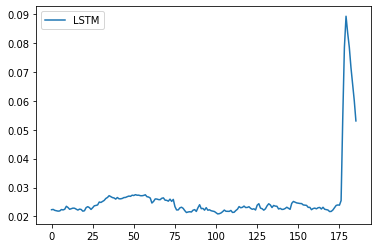

In [61]:
lstm_error.plot()

# LTAR

In [82]:
nondiff_ltar = LTAR(train_tensor)
nondiff_ltar.fit(n_steps, "dct")

In [83]:
result_tensor = nondiff_ltar.forecast(N_test)

In [85]:
nondiff_ltar_error = jts.calc_mape_per_matrix(test_tensor, result_tensor)
nondiff_ltar_error = nondiff_ltar_error.rename(columns={"MAPE": "LTAR with DCT"})
nondiff_ltar_error

,LTAR with DCT
0,0.00224856
1,0.00241562
2,0.00294021
3,0.00391952
4,0.00528858
...,...
181,0.102703
182,0.102368
183,0.102987
184,0.103009


<AxesSubplot:>

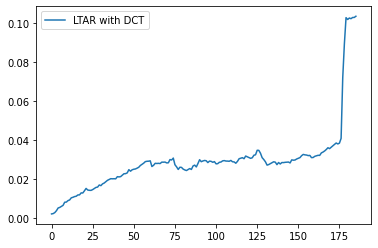

In [86]:
nondiff_ltar_error.plot()

# LTARI

In [87]:
diff_ltar = LTAR(diff(train_tensor))
diff_ltar.fit(n_steps, "dct")
result_tensor = invert_diff(diff_ltar.forecast(N_test), train_tensor)

In [88]:
diff_ltar_error = jts.calc_mape_per_matrix(test_tensor, result_tensor)
diff_ltar_error = diff_ltar_error.rename(columns={"MAPE": "LTARI with DCT"})
diff_ltar_error

,LTARI with DCT
0,0.00199243
1,0.00201203
2,0.0023448
3,0.00294069
4,0.00447149
...,...
181,0.078766
182,0.0785493
183,0.0786015
184,0.0779924


<AxesSubplot:>

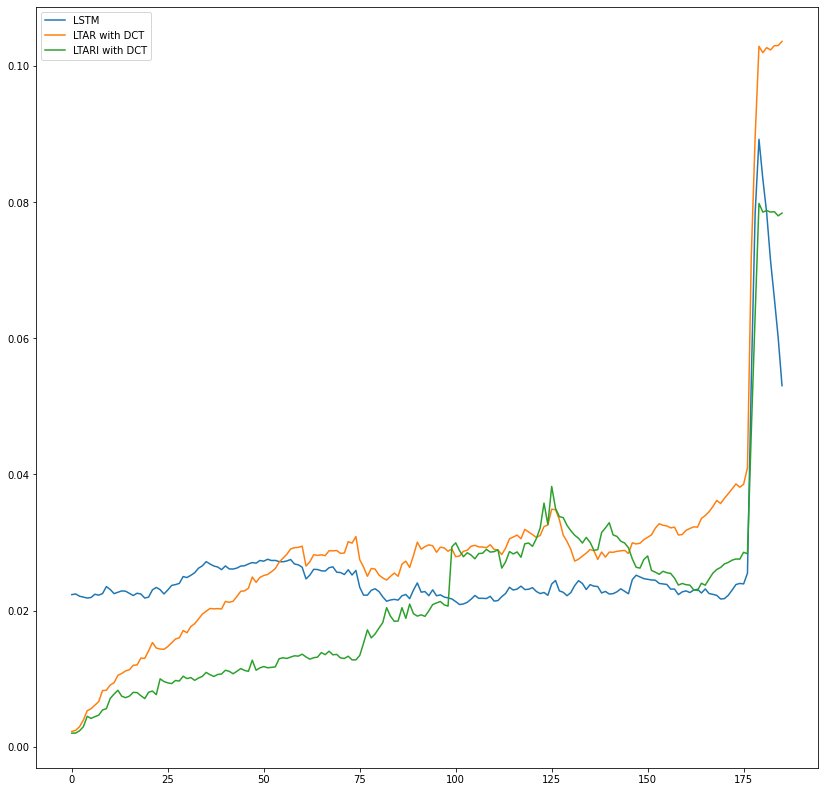

In [89]:
df = pd.concat([lstm_error, nondiff_ltar_error, diff_ltar_error], axis=1)
df.plot(figsize=(14, 14))